In [6]:
import os
import pandas as pd
from config import config
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [16]:
# df = pd.read_csv(os.path.join(config['path'], f'{config["station_id"]}-combined.csv'))
df = pd.read_csv(os.path.join(config['path'], 'test_file.csv'))
df['datetime'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' + df['ObsTime'].astype(str) + ':00:00'
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,Year,Month,Day,ObsTime,StnPres,Temperature,RH,WS,WD,Precp
datetime,,,,,,,,,,
2011-11-01 01:00:00,2011,11,1,1,1000.4,21.3,80.0,0.7,312.0,0.0
2011-11-01 02:00:00,2011,11,1,2,1000.0,21.1,81.0,1.1,308.0,0.0
2011-11-01 03:00:00,2011,11,1,3,1000.0,21.4,80.0,1.4,322.0,0.0
2011-11-01 04:00:00,2011,11,1,4,1000.0,22.3,77.0,0.9,45.0,0.0
2011-11-01 05:00:00,2011,11,1,5,1000.1,21.6,81.0,1.0,317.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-02-19 20:00:00,2023,2,19,20,1002.8,17.0,77.0,1.9,350.0,0.0
2023-02-19 21:00:00,2023,2,19,21,1003.2,16.9,78.0,2.5,351.0,0.0
2023-02-19 22:00:00,2023,2,19,22,1003.3,16.6,79.0,2.4,343.0,0.0


In [41]:
df = df.dropna(subset=['Temperature'])
df

,Year,Month,Day,ObsTime,StnPres,Temperature,RH,WS,WD,Precp
datetime,,,,,,,,,,
2011-11-01 01:00:00,2011,11,1,1,1000.4,21.3,80.0,0.7,312.0,0.0
2011-11-01 02:00:00,2011,11,1,2,1000.0,21.1,81.0,1.1,308.0,0.0
2011-11-01 03:00:00,2011,11,1,3,1000.0,21.4,80.0,1.4,322.0,0.0
2011-11-01 04:00:00,2011,11,1,4,1000.0,22.3,77.0,0.9,45.0,0.0
2011-11-01 05:00:00,2011,11,1,5,1000.1,21.6,81.0,1.0,317.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-02-19 19:00:00,2023,2,19,19,1002.2,17.3,75.0,2.5,346.0,0.0
2023-02-19 20:00:00,2023,2,19,20,1002.8,17.0,77.0,1.9,350.0,0.0
2023-02-19 21:00:00,2023,2,19,21,1003.2,16.9,78.0,2.5,351.0,0.0


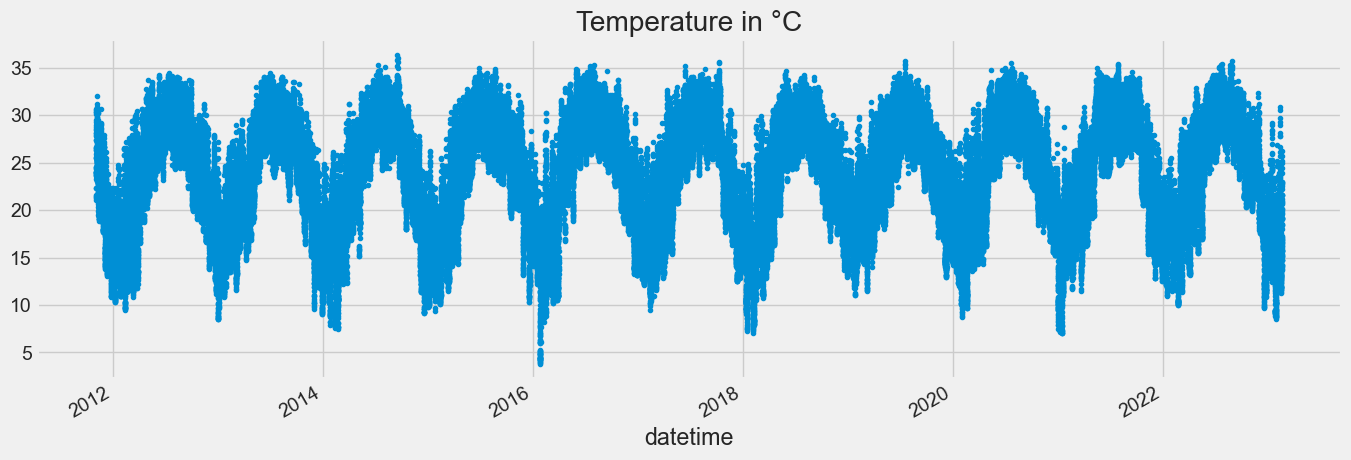

In [43]:
temp_data = df['Temperature']
temp_data.plot(style= '.',
               figsize=(15, 5),
               color=color_pal[0],
               title='Temperature in °C')
plt.show()